# COCO Pose Estimation Quality Metric

**Evaluating ControlNet-Generated Poses using YOLOv8-Pose & Procrustes Alignment**

This notebook compares poses from ControlNet-generated images against ground truth COCO keypoints using:
1. **COCO API** to extract ground truth keypoints from dataset
2. **YOLOv8-Pose** unified model for keypoint detection from generated images
3. **Procrustes Alignment** (translation + rotation + scale) to isolate pose shape
4. **MPJPE** (primary metric) and **OKS** (secondary metric) for evaluation

**Key Innovation:**
- Procrustes alignment removes location, size, and orientation differences → measures pure **pose shape similarity**
- MPJPE: Mean Per Joint Position Error (lower = better)
- OKS: Object Keypoint Similarity (higher = better)

**Workflow:**
- Load 300 images from val_captions.json
- Extract COCO ground truth keypoints
- Run YOLOv8-Pose on generated images
- Align predictions using Procrustes analysis
- Compare using MPJPE and OKS metrics

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Install & Verify Dependencies

In [2]:
# Install basic dependencies
%pip install -q numpy pandas matplotlib seaborn scipy
%pip install -q opencv-python
%pip install -q pycocotools

import sys
print(f"Python version: {sys.version}")

# Install YOLOv8-Pose (ultralytics) - simple, no dependency hell
print("Installing YOLOv8-Pose (ultralytics)...")
%pip install -q -U ultralytics torch torchvision

print("✓ Installation complete (YOLOv8-Pose)!")
print("  No MMPose/MMDetection/OpenMMLab compilation issues!")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Installing YOLOv8-Pose (ultralytics)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 787.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 147.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [3]:
# Verify installation
import sys
import torch
print(f"Python: {sys.version}")
print(f"Torch:   {torch.__version__}, CUDA available: {torch.cuda.is_available()}")

try:
    from ultralytics import YOLO
    print(f"Ultralytics (YOLOv8): ✓ imported successfully")
except Exception as e:
    print(f"Ultralytics import failed: {type(e).__name__}: {e}")
    raise

try:
    import cv2
    import numpy as np
    import pandas as pd
    print(f"Core libs (cv2, numpy, pandas): ✓ imported successfully")
    print("\n✅ All packages loaded successfully (YOLOv8-Pose ready!)")
except Exception as e:
    print(f"Core libs import failed: {type(e).__name__}: {e}")
    raise

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch:   2.9.1+cu128, CUDA available: True
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics (YOLOv8): ✓ imported successfully
Core libs (cv2, numpy, pandas): ✓ imported successfully

✅ All packages loaded successfully (YOLOv8-Pose ready!)


In [4]:
# Imports and configuration
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Tuple
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from ultralytics import YOLO

# Paths
VAL_CAPTIONS_PATH = "/content/val_captions.json"
GENERATED_IMAGES_PATH = "/content/drive/MyDrive/generatedimages"  # e.g., "./generated_images"
NUM_IMAGES = 300

# YOLOv8-Pose model configuration
YOLO_MODEL = 'yolov8m-pose.pt'  # medium: good balance of speed/accuracy (m,s,l,x available)
CONF_THRESHOLD = 0.4  # confidence threshold for detections

# COCO keypoint names (YOLOv8 outputs in COCO-17 format)
COCO_KEYPOINT_NAMES = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

# COCO skeleton connections
SKELETON = [
    (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6),
    (5, 7), (7, 9), (6, 8), (8, 10), (5, 11), (6, 12),
    (11, 13), (13, 15), (12, 14), (14, 16)
]

print("✓ Imports & config loaded")
print(f"  Val Captions: {VAL_CAPTIONS_PATH}")
print(f"  Generated Images: {GENERATED_IMAGES_PATH}")
print(f"  Model: {YOLO_MODEL} (YOLOv8-Pose)")
print(f"  Confidence threshold: {CONF_THRESHOLD}")

✓ Imports & config loaded
  Val Captions: /content/val_captions.json
  Generated Images: /content/drive/MyDrive/generatedimages
  Model: yolov8m-pose.pt (YOLOv8-Pose)
  Confidence threshold: 0.4


## 2. Configuration & Dataset Setup

Load COCO annotations and extract ground truth keypoints

In [5]:
# Load val_captions.json
print("Loading val_captions.json...")
with open(VAL_CAPTIONS_PATH, 'r') as f:
    val_captions_raw = json.load(f)

# Handle different JSON structures
image_ids = []

if isinstance(val_captions_raw, dict):
    # Check if it's a filename->caption dictionary (e.g., {"000000480936.jpg": "caption text"})
    sample_key = next(iter(val_captions_raw.keys())) if val_captions_raw else None

    if sample_key and isinstance(sample_key, str) and sample_key.endswith(('.jpg', '.jpeg', '.png')):
        # Format: {"filename.jpg": "caption"}
        print("Detected filename->caption dictionary format")

        # Extract image IDs from filenames
        for filename in list(val_captions_raw.keys())[:NUM_IMAGES]:
            # Extract numeric ID from filename like "000000480936.jpg"
            # Remove extension and any leading zeros
            basename = filename.rsplit('.', 1)[0]  # "000000480936"
            try:
                img_id = int(basename)  # Convert to integer (removes leading zeros)
                image_ids.append(img_id)
            except ValueError:
                print(f"  Warning: Could not extract ID from filename: {filename}")

    elif 'annotations' in val_captions_raw:
        val_captions = val_captions_raw['annotations']
        for cap in val_captions[:NUM_IMAGES]:
            if isinstance(cap, dict):
                img_id = cap.get('image_id') or cap.get('id') or cap.get('image')
                if img_id and img_id not in image_ids:
                    image_ids.append(img_id)

    elif 'images' in val_captions_raw:
        val_captions = val_captions_raw['images']
        for cap in val_captions[:NUM_IMAGES]:
            if isinstance(cap, dict):
                img_id = cap.get('image_id') or cap.get('id') or cap.get('image')
                if img_id and img_id not in image_ids:
                    image_ids.append(img_id)

    else:
        # Try to use the values if they look like a list
        vals = list(val_captions_raw.values())
        if vals and isinstance(vals[0], dict):
            for cap in vals[:NUM_IMAGES]:
                img_id = cap.get('image_id') or cap.get('id') or cap.get('image')
                if img_id and img_id not in image_ids:
                    image_ids.append(img_id)

elif isinstance(val_captions_raw, list):
    for cap in val_captions_raw[:NUM_IMAGES]:
        if isinstance(cap, dict):
            img_id = cap.get('image_id') or cap.get('id') or cap.get('image')
            if img_id and img_id not in image_ids:
                image_ids.append(img_id)

if not image_ids:
    raise ValueError(f"Could not extract image IDs from val_captions.json. Please check the file format.")

print(f"Total captions: {len(val_captions_raw) if isinstance(val_captions_raw, dict) else len(val_captions_raw)}")
print(f"Extracted {len(image_ids)} unique image IDs from first {NUM_IMAGES} entries")
print(f"Sample image IDs: {image_ids[:5]}")

# ============================================
# Download COCO annotations on-the-fly
# ============================================
print("\n" + "="*70)
print("Downloading COCO annotations on-the-fly...")
print("="*70)

import urllib.request
import tempfile
import zipfile
import os

# Download COCO keypoints annotation JSON
print("Downloading COCO annotations (annotations_trainval2017.zip)...")
print("(This may take 2-3 minutes, file is ~250MB)")

try:
    # Use a cache directory
    cache_dir = Path.home() / ".cache" / "coco_annotations"
    cache_dir.mkdir(parents=True, exist_ok=True)
    cache_file = cache_dir / "person_keypoints_val2017.json"

    if cache_file.exists():
        print(f"Using cached annotations from {cache_file}")
        with open(cache_file, 'r') as f:
            coco_annotations = json.load(f)
    else:
        # Download the zip file containing all annotations
        zip_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
        zip_path = cache_dir / "annotations_trainval2017.zip"

        print(f"Downloading annotations zip file...")

        # Download with progress
        def download_progress(blocknum, blocksize, totalsize):
            downloaded = blocknum * blocksize
            percent = min(downloaded * 100 / totalsize, 100)
            print(f"  Progress: {percent:.1f}% ({downloaded / 1024 / 1024:.1f}MB / {totalsize / 1024 / 1024:.1f}MB)", end='\r')

        urllib.request.urlretrieve(zip_url, zip_path, reporthook=download_progress)
        print("\n✓ Download complete!")

        # Extract the specific JSON file we need
        print(f"Extracting person_keypoints_val2017.json...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract only the file we need
            target_file = "annotations/person_keypoints_val2017.json"
            zip_ref.extract(target_file, cache_dir)

            # Move to cache location
            extracted_path = cache_dir / target_file
            extracted_path.rename(cache_file)

            # Clean up
            (cache_dir / "annotations").rmdir()

        # Remove zip file to save space
        zip_path.unlink()
        print(f"✓ Extracted to {cache_file}")

        # Load the annotations
        with open(cache_file, 'r') as f:
            coco_annotations = json.load(f)

    print("✓ COCO annotations loaded successfully")

except Exception as e:
    print(f"✗ Error downloading COCO annotations: {e}")
    print("Make sure you have internet connection")
    raise

# ============================================
# Extract ground truth keypoints
# ============================================
print("\nProcessing COCO annotations...")

# Build lookup: image_id -> annotations
coco_images = {img['id']: img for img in coco_annotations.get('images', [])}
coco_annotations_by_img = {}

for ann in coco_annotations.get('annotations', []):
    img_id = ann['image_id']
    if img_id not in coco_annotations_by_img:
        coco_annotations_by_img[img_id] = []
    coco_annotations_by_img[img_id].append(ann)

print(f"Total images in COCO: {len(coco_images)}")
print(f"Total annotations in COCO: {len(coco_annotations.get('annotations', []))}")

# Extract ground truth keypoints for our images
gt_keypoints_dict = {}  # {image_id: {ann_id: keypoints}}

print(f"\nExtracting ground truth keypoints for {len(image_ids)} images...")
for idx, img_id in enumerate(image_ids):
    if (idx + 1) % 10 == 0:
        print(f"  [{idx+1}/{len(image_ids)}]", end='\r')

    # Get annotations for this image
    anns = coco_annotations_by_img.get(img_id, [])

    if anns:
        gt_keypoints_dict[img_id] = {}
        for ann in anns:
            if 'keypoints' in ann:
                # COCO format: [x1, y1, v1, x2, y2, v2, ...]
                kpts = np.array(ann['keypoints']).reshape(17, 3)  # 17 keypoints, (x, y, v)
                gt_keypoints_dict[img_id][ann['id']] = {
                    'keypoints': kpts,
                    'bbox': ann.get('bbox'),
                    'area': ann.get('area'),
                    'iscrowd': ann.get('iscrowd', 0),
                    'category_id': ann.get('category_id')
                }

print(f"\n✓ Found ground truth for {len(gt_keypoints_dict)} images")
total_anns = sum(len(v) for v in gt_keypoints_dict.values())
print(f"  Total annotations: {total_anns}")
print(f"  Images without keypoint annotations: {len(image_ids) - len(gt_keypoints_dict)}")

Loading val_captions.json...
Detected filename->caption dictionary format
Total captions: 300
Extracted 300 unique image IDs from first 300 entries
Sample image IDs: [480936, 102820, 311394, 551439, 368212]

(This may take 2-3 minutes, file is ~250MB)
  Progress: 100.0% (241.2MB / 241.2MB)
✓ Download complete!
Extracting person_keypoints_val2017.json...
✓ Extracted to /root/.cache/coco_annotations/person_keypoints_val2017.json
✓ COCO annotations loaded successfully

Processing COCO annotations...
Total images in COCO: 5000
Total annotations in COCO: 11004

Extracting ground truth keypoints for 300 images...
  [300/300]
✓ Found ground truth for 300 images
  Total annotations: 868
  Images without keypoint annotations: 0


## 3. Load YOLOv8-Pose Model

In [6]:
import torch

print("Loading YOLOv8-Pose model...")
print("(Model will auto-download on first run)\n")

try:
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load YOLOv8-Pose model (unified detection + pose estimation)
    # Auto-downloads pretrained weights on first run
    yolo_model = YOLO(YOLO_MODEL)
    yolo_model.to(device)

    print(f"✓ YOLOv8-Pose model loaded successfully")
    print(f"  Model: {YOLO_MODEL}")
    print(f"  Device: {device}")
    print(f"  Unified detection + pose (no separate pipeline)")

except Exception as e:
    print(f"✗ Error loading YOLOv8-Pose: {e}")
    import traceback
    traceback.print_exc()
    raise

Loading YOLOv8-Pose model...
(Model will auto-download on first run)

✓ YOLOv8-Pose model loaded successfully
  Model: yolov8m-pose.pt
  Device: cuda
  Unified detection + pose (no separate pipeline)


## 4. Helper Functions & Metrics

Procrustes Alignment + MPJPE + OKS computation

In [7]:
def extract_keypoints_from_generated_image(image_path: str) -> List[np.ndarray]:
    """
    YOLOv8-Pose: Single unified model for detection + pose estimation.
    Returns list of keypoint arrays (17,3) per detected person, or None.

    Args:
        image_path: Path to image file

    Returns:
        List of (17,3) arrays: [x, y, confidence] for each person's 17 keypoints
        Returns None if no persons detected
    """
    global yolo_model

    # Run YOLOv8-Pose inference (unified detection + pose in one call)
    results = yolo_model(image_path, conf=CONF_THRESHOLD, verbose=False)

    if not results or len(results) == 0:
        return None

    result = results[0]  # First (only) result for single image

    # Check if keypoints detected
    if result.keypoints is None or len(result.keypoints) == 0:
        return None

    # Extract keypoints for all detected persons
    keypoints_xy = result.keypoints.xy   # (N_persons, 17, 2)
    confidences = result.keypoints.conf  # (N_persons, 17)

    if keypoints_xy is None or len(keypoints_xy) == 0:
        return None

    detections = []
    for i in range(len(keypoints_xy)):
        # Combine x,y coords with confidence: (17,3)
        # Move to CPU and convert to numpy (handles both CUDA and CPU tensors)
        kpts_17 = keypoints_xy[i].cpu().numpy()  # (17, 2)
        conf_17 = confidences[i].cpu().numpy().reshape(17, 1)  # (17, 1)
        kpts_with_conf = np.concatenate([kpts_17, conf_17], axis=1)  # (17, 3)
        detections.append(kpts_with_conf)

    return detections if len(detections) > 0 else None


def procrustes_align(gt_keypoints: np.ndarray, pred_keypoints: np.ndarray) -> np.ndarray:
    """
    Align predicted keypoints to ground truth using Procrustes analysis.
    Handles translation, rotation, and uniform scaling.
    This makes comparison focus on pose SHAPE, not location/size/orientation.

    Args:
        gt_keypoints: (17, 3) ground truth [x, y, visibility]
        pred_keypoints: (17, 3) predicted [x, y, confidence]

    Returns:
        Aligned predicted keypoints (17, 3)
    """
    # Extract visible keypoints for alignment
    gt_visible = gt_keypoints[:, 2] > 0
    pred_visible = pred_keypoints[:, 2] > 0

    # Find common visible keypoints
    common_visible = gt_visible & pred_visible

    if common_visible.sum() < 3:  # Need at least 3 points for meaningful alignment
        return pred_keypoints

    # Extract visible x,y coordinates
    gt_points = gt_keypoints[common_visible, :2]  # (N, 2)
    pred_points = pred_keypoints[common_visible, :2]  # (N, 2)

    # Step 1: Center both point sets (translation to origin)
    gt_centroid = gt_points.mean(axis=0)
    pred_centroid = pred_points.mean(axis=0)

    gt_centered = gt_points - gt_centroid
    pred_centered = pred_points - pred_centroid

    # Step 2: Compute optimal rotation using SVD
    # H = pred_centered.T @ gt_centered
    H = pred_centered.T @ gt_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Ensure proper rotation (det(R) = 1, not -1 for reflection)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Step 3: Compute optimal scale
    # scale = trace(S) / sum_of_squared_distances(pred_centered)
    pred_scale = np.sum(pred_centered ** 2)
    if pred_scale > 0:
        scale = np.trace(np.diag(S)) / pred_scale
    else:
        scale = 1.0

    # Step 4: Apply transformation to ALL predicted keypoints (not just visible)
    aligned_pred = pred_keypoints.copy()

    # Center
    aligned_pred[:, :2] = aligned_pred[:, :2] - pred_centroid

    # Scale
    aligned_pred[:, :2] = aligned_pred[:, :2] * scale

    # Rotate
    aligned_pred[:, :2] = (R @ aligned_pred[:, :2].T).T

    # Translate to GT centroid
    aligned_pred[:, :2] = aligned_pred[:, :2] + gt_centroid

    return aligned_pred


def compute_mpjpe(gt_keypoints: np.ndarray, pred_keypoints: np.ndarray) -> Dict:
    """
    Compute Mean Per Joint Position Error (MPJPE).
    Measures average Euclidean distance between corresponding keypoints.

    Args:
        gt_keypoints: (17, 3) ground truth [x, y, visibility]
        pred_keypoints: (17, 3) predicted [x, y, confidence]

    Returns:
        Dict with mpjpe (mean error), per_joint_errors, and num_visible
    """
    # Only compute error for visible GT keypoints
    visible = gt_keypoints[:, 2] > 0

    if visible.sum() == 0:
        return {
            'mpjpe': 0.0,
            'per_joint_errors': np.zeros(17),
            'num_visible': 0
        }

    # Compute Euclidean distance for each keypoint
    dx = pred_keypoints[:, 0] - gt_keypoints[:, 0]
    dy = pred_keypoints[:, 1] - gt_keypoints[:, 1]
    distances = np.sqrt(dx**2 + dy**2)

    # Mean over visible keypoints
    mpjpe = distances[visible].mean()

    return {
        'mpjpe': float(mpjpe),
        'per_joint_errors': distances,
        'num_visible': int(visible.sum())
    }


def compute_oks(gt_keypoints: np.ndarray, pred_keypoints: np.ndarray, bbox: np.ndarray) -> float:
    """Compute Object Keypoint Similarity (OKS)."""
    sigmas = np.array([
        .26, .25, .25, .35, .35, .79, .79, .72, .72, .62, .62, 1.07, 1.07, .87, .87, .89, .89
    ]) / 10.0
    x, y, w, h = bbox
    scale = w * h
    if scale <= 0:
        return 0.0
    dx = pred_keypoints[:, 0] - gt_keypoints[:, 0]
    dy = pred_keypoints[:, 1] - gt_keypoints[:, 1]
    d_squared = dx**2 + dy**2
    visible = gt_keypoints[:, 2] > 0
    if visible.sum() == 0:
        return 0.0
    oks_per_kpt = np.exp(-d_squared / (2 * scale * sigmas**2))
    oks = (oks_per_kpt * visible).sum() / visible.sum()
    return float(oks)

print("✓ Helper functions defined")
print("  - YOLOv8-Pose extraction")
print("  - Procrustes alignment (translation + rotation + scale)")
print("  - MPJPE (Mean Per Joint Position Error)")
print("  - OKS (Object Keypoint Similarity)")

✓ Helper functions defined
  - YOLOv8-Pose extraction
  - Procrustes alignment (translation + rotation + scale)
  - MPJPE (Mean Per Joint Position Error)
  - OKS (Object Keypoint Similarity)


## 5. Extract Keypoints from Generated Images

In [8]:
print("="*70)
print("EXTRACTING KEYPOINTS FROM GENERATED IMAGES")
print("="*70)

# Load all generated images from folder
gen_images_dir = Path(GENERATED_IMAGES_PATH)
if not gen_images_dir.exists():
    raise FileNotFoundError(f"Generated images directory not found: {GENERATED_IMAGES_PATH}")

# Collect all image files (png/jpg/jpeg, case-insensitive)
image_extensions = ['.png', '.jpg', '.jpeg']
generated_image_files = []
for ext in image_extensions:
    generated_image_files.extend(gen_images_dir.glob(f'*{ext}'))
    generated_image_files.extend(gen_images_dir.glob(f'*{ext.upper()}'))

# Deduplicate
generated_image_files = list(dict.fromkeys(generated_image_files))
print(f"Found {len(generated_image_files)} generated images in {GENERATED_IMAGES_PATH}")
print(f"Need matches for {len(image_ids)} validation captions")

# Helper: find file whose name contains the image id
def find_generated_image_for_id(img_id: int) -> Path:
    id_plain = str(img_id)
    id_padded = f"{img_id:012d}"
    candidates = []
    for f in generated_image_files:
        name = f.name
        if not name.lower().startswith("generated_"):
            continue
        if id_plain in name or id_padded in name:
            candidates.append(f)
    if not candidates:
        return None
    # Prefer exact plain match, then padded, else first candidate
    for f in candidates:
        if f"generated_{id_plain}" in f.name:
            return f
    for f in candidates:
        if f"generated_{id_padded}" in f.name:
            return f
    return sorted(candidates)[0]

# Test extraction on first image
print("\n🔍 Testing YOLOv8-Pose extraction on first image...")
test_img_id = image_ids[0]
test_img_path = find_generated_image_for_id(test_img_id)
if test_img_path:
    print(f"Test image: {test_img_path}")
    try:
        test_kpts_list = extract_keypoints_from_generated_image(str(test_img_path))
        if test_kpts_list:
            print(f"✓ Extracted {len(test_kpts_list)} person(s) with keypoints; first shape: {test_kpts_list[0].shape}")
        else:
            print("✗ Extraction returned None or empty list")
    except Exception as e:
        print(f"✗ Extraction error: {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"✗ Could not find test image for ID {test_img_id}")

print("\n" + "="*70)

generated_keypoints_dict = {}  # {image_id: [keypoints_array_per_person]}
missing_images = []
extraction_failures = []

print("\nMatching generated images by filename substring (image id) ...\n")

for idx, img_id in enumerate(image_ids):
    if (idx + 1) % 10 == 0:
        print(f"  [{idx+1}/{len(image_ids)}] Processed", end='\r')

    gen_img_path = find_generated_image_for_id(img_id)

    if gen_img_path is None:
        missing_images.append(img_id)
        continue

    # Extract keypoints (all detected persons)
    try:
        kpts_list = extract_keypoints_from_generated_image(str(gen_img_path))

        if kpts_list:
            generated_keypoints_dict[img_id] = kpts_list
        else:
            extraction_failures.append((img_id, "Extraction returned None or empty"))
    except Exception as e:
        error_msg = f"{type(e).__name__}: {str(e)}" if str(e) else type(e).__name__
        extraction_failures.append((img_id, error_msg))

print(f"\n\n✓ Processed {len(image_ids)} target images")
print(f"  Successfully extracted (>=1 person): {len(generated_keypoints_dict)}")
print(f"  Missing images: {len(missing_images)}")
print(f"  Extraction failures: {len(extraction_failures)}")

if missing_images[:5]:
    print(f"\n  First 5 missing image IDs: {missing_images[:5]}")
    print(f"  ⚠️ Ensure filenames include the image id, e.g., generated_<id>.png")

if extraction_failures[:5]:
    print(f"\n  First 5 extraction failures:")
    for img_id, reason in extraction_failures[:5]:
        print(f"    - Image {img_id}: {reason}")

EXTRACTING KEYPOINTS FROM GENERATED IMAGES
Found 300 generated images in /content/drive/MyDrive/generatedimages
Need matches for 300 validation captions

🔍 Testing YOLOv8-Pose extraction on first image...
Test image: /content/drive/MyDrive/generatedimages/generated_480936.jpeg
✓ Extracted 1 person(s) with keypoints; first shape: (17, 3)


Matching generated images by filename substring (image id) ...

  [300/300] Processed

✓ Processed 300 target images
  Successfully extracted (>=1 person): 300
  Missing images: 0
  Extraction failures: 0


## 6. Compute Pose Shape Similarity Metrics

MPJPE (primary) and OKS (secondary) using Procrustes-aligned predictions

In [12]:
print("\n" + "="*70)
print("COMPUTING POSE SHAPE SIMILARITY METRICS")
print("="*70)

# Validate that we have both GT and predictions
print(f"\nValidation:")
print(f"  Images with GT keypoints: {len(gt_keypoints_dict)}")
print(f"  Images with predicted keypoints (any person): {len(generated_keypoints_dict)}")

# Find intersection
common_images = set(gt_keypoints_dict.keys()) & set(generated_keypoints_dict.keys())
print(f"  Images with both GT and predictions: {len(common_images)}")

if len(common_images) == 0:
    print("\n✗ ERROR: No images have both GT and predicted keypoints!")
    print("Please check:")
    print("  1. Generated images are in the correct folder")
    print("  2. Image naming matches one of the patterns")
    print("  3. YOLOv8-Pose is correctly detecting poses")
    raise ValueError("No valid image pairs for comparison")

print(f"\n✓ Ready to compare {len(common_images)} image-annotation pairs")

results = []
best_generated_keypoints_dict_aligned = {}  # {image_id: best Procrustes-aligned kpts (17,3)}
best_generated_keypoints_dict_raw = {}       # {image_id: best raw kpts (17,3)}

total_skipped_low_vis = 0
comparison_count = 0

print("\n📍 Strategy: Procrustes Alignment + MPJPE for Pose Shape Similarity")
print("   ✓ Translation: Centering to same location")
print("   ✓ Rotation: Optimal angle alignment")
print("   ✓ Scale: Uniform scaling to same size")
print("   → Measures PURE POSE SHAPE, ignoring location/size/orientation\n")

for img_id in common_images:
    gt_data = gt_keypoints_dict[img_id]

    if len(gt_data) == 0:
        continue

    ann_id = list(gt_data.keys())[0]
    gt_info = gt_data[ann_id]
    gt_kpts = gt_info['keypoints']  # (17, 3)
    gt_bbox = gt_info['bbox']  # [x, y, width, height]

    # Skip if labeled keypoints < 10
    visible_count = int((gt_kpts[:, 2] > 0).sum())
    if visible_count < 10:
        total_skipped_low_vis += 1
        continue

    # Get predictions from generated image
    if img_id not in generated_keypoints_dict:
        continue

    pred_kpts_list = generated_keypoints_dict[img_id]

    if not pred_kpts_list or len(pred_kpts_list) == 0:
        continue

    # ============================================================
    # Compare ALL detected poses, take BEST match (lowest MPJPE)
    # Use PROCRUSTES ALIGNMENT for pose shape comparison
    # ============================================================
    best_mpjpe = float('inf')
    best_pred_aligned = None
    best_pred_raw = None
    best_oks = 0.0

    for pred_kpts in pred_kpts_list:
        # PROCRUSTES ALIGN: translation + rotation + scale
        aligned_pred = procrustes_align(gt_kpts, pred_kpts)

        # Compute MPJPE (Mean Per Joint Position Error) - primary metric
        mpjpe_result = compute_mpjpe(gt_kpts, aligned_pred)
        mpjpe = mpjpe_result['mpjpe']

        # Also compute OKS
        oks = compute_oks(gt_kpts, aligned_pred, gt_bbox)

        # Keep track of best match (lowest MPJPE = best shape match)
        if mpjpe < best_mpjpe:
            best_mpjpe = mpjpe
            best_pred_aligned = aligned_pred
            best_pred_raw = pred_kpts
            best_oks = oks

    if best_pred_aligned is None:
        continue

    results.append({
        'image_id': img_id,
        'annotation_id': ann_id,
        'mpjpe': best_mpjpe,  # Primary metric: lower = better pose shape match
        'oks': best_oks,      # Secondary: higher = better
        'num_detected_poses': len(pred_kpts_list)
    })

    best_generated_keypoints_dict_aligned[img_id] = best_pred_aligned
    best_generated_keypoints_dict_raw[img_id] = best_pred_raw
    comparison_count += 1

print(f"\nCompared {comparison_count} image-annotation pairs")
print(f"Skipped (labeled keypoints < 10): {total_skipped_low_vis}")

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)

print("\n" + "="*70)
print("📊 POSE SHAPE SIMILARITY RESULTS")
print("   (Procrustes-aligned: translation + rotation + scale)")
print("="*70)

print(f"\n🎯 MPJPE (Mean Per Joint Position Error) - PRIMARY METRIC:")
print(f"   Lower is better (measures pose shape similarity)")
print(f"  Mean:   {results_df['mpjpe'].mean():.2f} pixels")
print(f"  Median: {results_df['mpjpe'].median():.2f} pixels")
print(f"  Std:    {results_df['mpjpe'].std():.2f} pixels")
print(f"  Min:    {results_df['mpjpe'].min():.2f} pixels (best)")
print(f"  Max:    {results_df['mpjpe'].max():.2f} pixels (worst)")

print(f"\nOKS (Object Keypoint Similarity) - SECONDARY METRIC:")
print(f"  Mean:   {results_df['oks'].mean():.4f}")
print(f"  Median: {results_df['oks'].median():.4f}")
print(f"  Std:    {results_df['oks'].std():.4f}")
print(f"  Min:    {results_df['oks'].min():.4f}")
print(f"  Max:    {results_df['oks'].max():.4f}")


COMPUTING POSE SHAPE SIMILARITY METRICS

Validation:
  Images with GT keypoints: 300
  Images with predicted keypoints (any person): 300
  Images with both GT and predictions: 300

✓ Ready to compare 300 image-annotation pairs

📍 Strategy: Procrustes Alignment + MPJPE for Pose Shape Similarity
   ✓ Translation: Centering to same location
   ✓ Rotation: Optimal angle alignment
   ✓ Scale: Uniform scaling to same size
   → Measures PURE POSE SHAPE, ignoring location/size/orientation


Compared 293 image-annotation pairs
Skipped (labeled keypoints < 10): 7

📊 POSE SHAPE SIMILARITY RESULTS
   (Procrustes-aligned: translation + rotation + scale)

🎯 MPJPE (Mean Per Joint Position Error) - PRIMARY METRIC:
   Lower is better (measures pose shape similarity)
  Mean:   23.91 pixels
  Median: 19.37 pixels
  Std:    16.73 pixels
  Min:    4.54 pixels (best)
  Max:    129.80 pixels (worst)

OKS (Object Keypoint Similarity) - SECONDARY METRIC:
  Mean:   0.5557
  Median: 0.5861
  Std:    0.2005
  Mi

## 7. Visualization: Best & Worst Pose Examples

Ranked by MPJPE (lower = better pose shape match)

Visualizing samples with best and worst pose shape similarity...
(Ranked by MPJPE: lower = better pose shape match)
(Left: Generated images | Right: Original COCO images with GT poses)



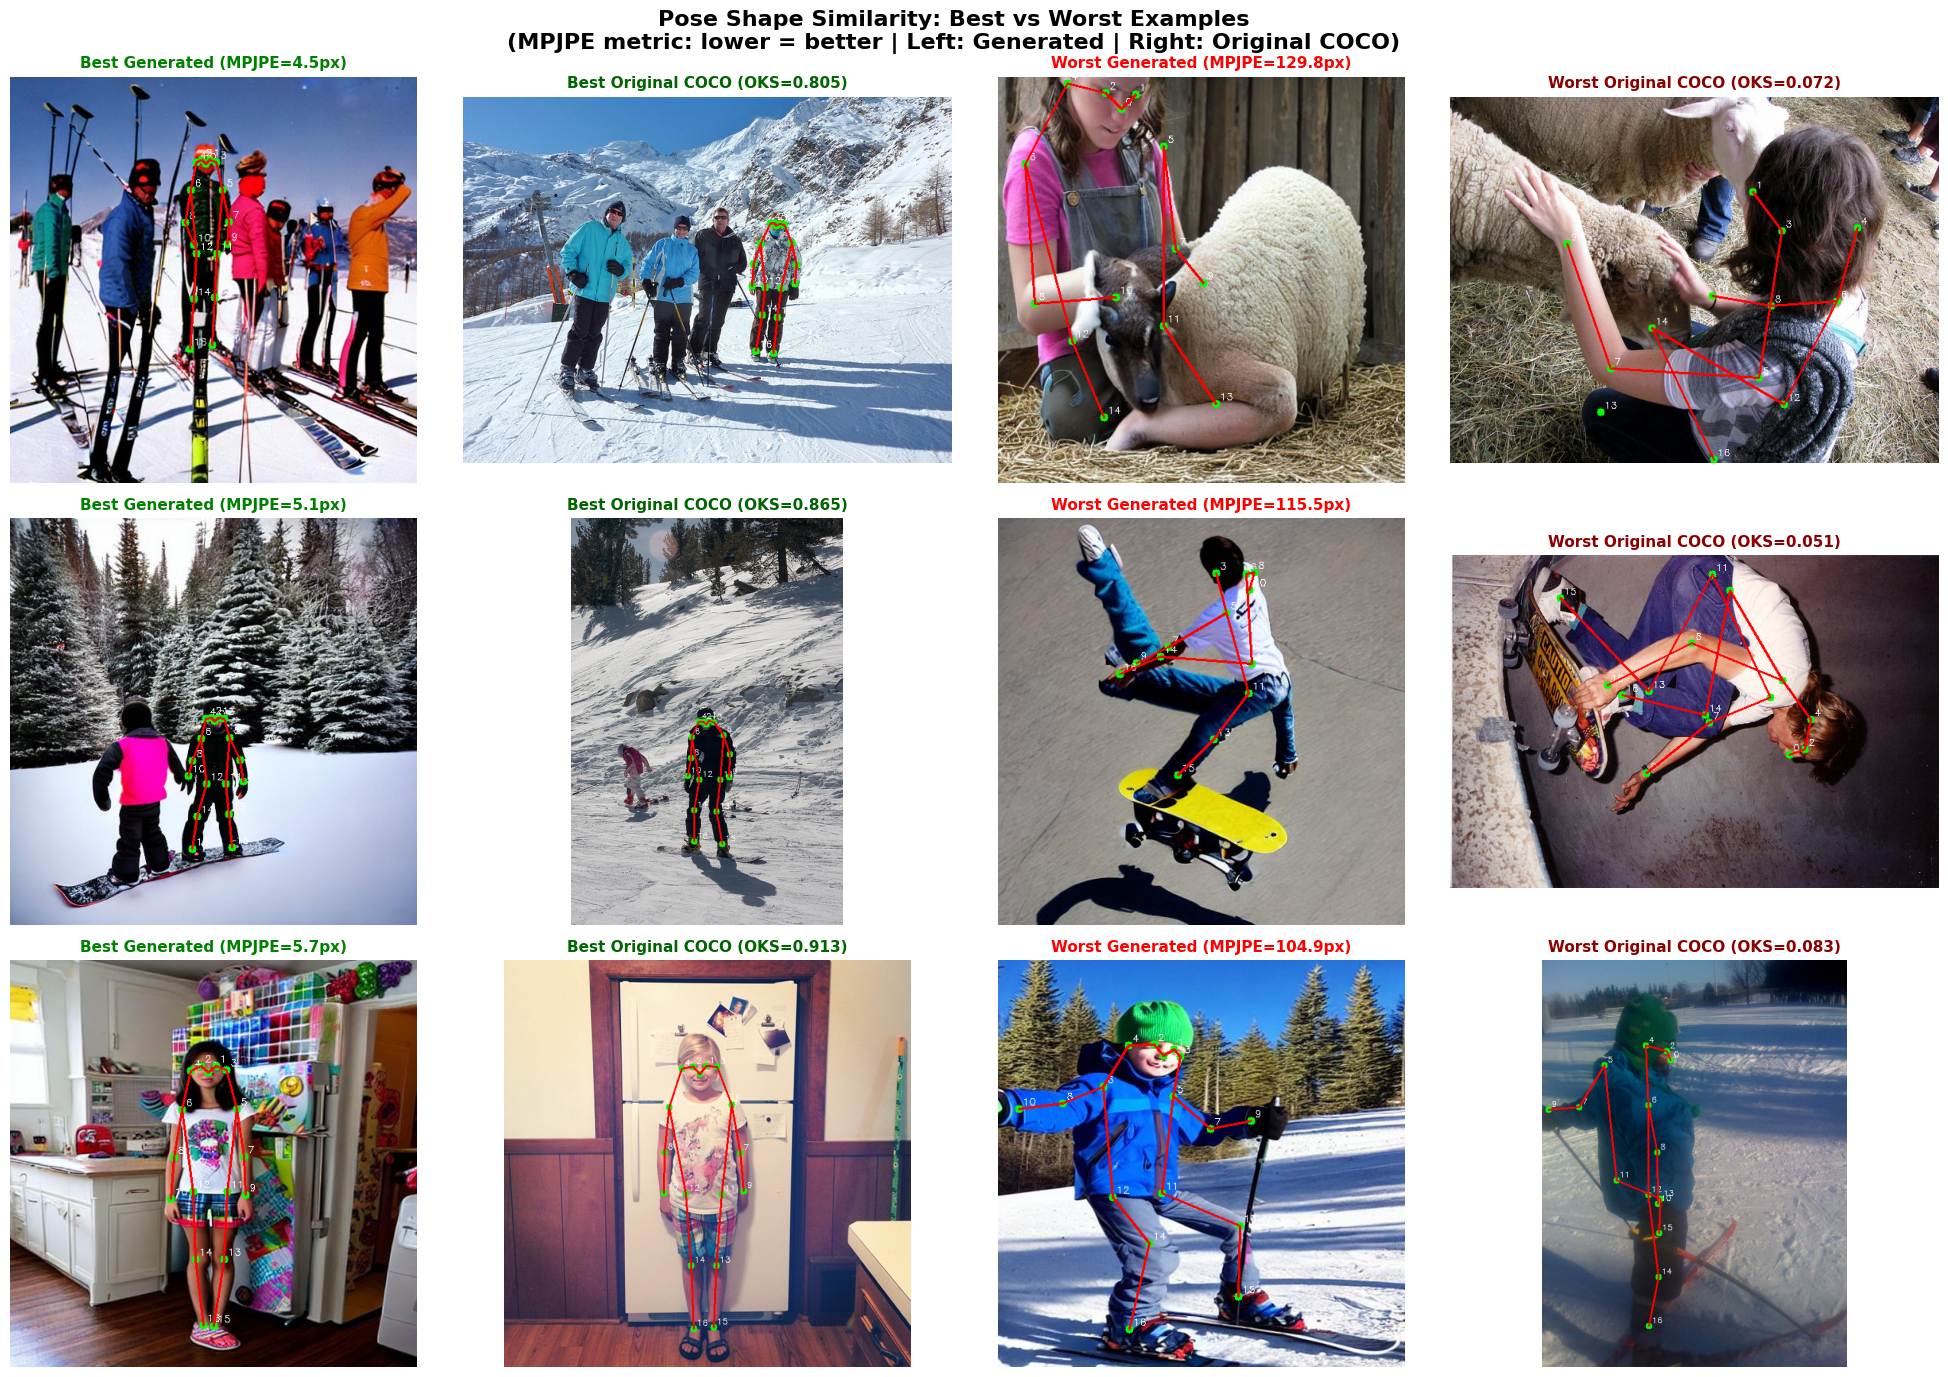

In [17]:
# def draw_skeleton(image, keypoints, skeleton, title=""):
#     """Draw skeleton on image."""
#     image = image.copy()
#     # Draw keypoints
#     for kpt_idx, (x, y, conf) in enumerate(keypoints):
#         if conf > 0.3:  # Only draw if confidence > 0.3
#             cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
#             cv2.putText(image, str(kpt_idx), (int(x) + 5, int(y) - 5),
#                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

#     # Draw skeleton connections
#     for start, end in skeleton:
#         if keypoints[start, 2] > 0.3 and keypoints[end, 2] > 0.3:
#             x1, y1, _ = keypoints[start]
#             x2, y2, _ = keypoints[end]
#             cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

#     return image


# def find_generated_image_for_id(img_id: int) -> Path:
#     """Locate generated image by id in GENERATED_IMAGES_PATH."""
#     gen_dir = Path(GENERATED_IMAGES_PATH)
#     if not gen_dir.exists():
#         return None
#     id_plain = str(img_id)
#     id_padded = f"{img_id:012d}"
#     image_extensions = ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']
#     candidates = []
#     for ext in image_extensions:
#         for f in gen_dir.glob(f"generated_*{ext}"):
#             name = f.name
#             if id_plain in name or id_padded in name:
#                 candidates.append(f)
#     if not candidates:
#         return None
#     # Prefer exact plain match, then padded
#     for f in candidates:
#         if f"generated_{id_plain}" in f.name:
#             return f
#     for f in candidates:
#         if f"generated_{id_padded}" in f.name:
#             return f
#     return sorted(candidates)[0]


# # Show a few examples (samples with best and worst MPJPE)
# print("Visualizing samples with best and worst pose shape similarity...")
# print("(Ranked by MPJPE: lower = better pose shape match)")
# print("(Showing RAW detected poses as they appear in generated images)\n")

# if results_df.empty:
#     print("✗ No results to visualize. Run metric computation first.")
# else:
#     # Sort by MPJPE: lowest = best shape match
#     best_indices = results_df.nsmallest(3, 'mpjpe').index
#     worst_indices = results_df.nlargest(3, 'mpjpe').index

#     fig, axes = plt.subplots(3, 2, figsize=(16, 14))
#     fig.suptitle('Pose Shape Similarity: Best vs Worst Examples\n(MPJPE metric: lower = better | Poses shown as detected in generated images)',
#                  fontsize=16, fontweight='bold')

#     for row, (best_idx, worst_idx) in enumerate(zip(best_indices, worst_indices)):
#         best_result = results_df.iloc[best_idx]
#         worst_result = results_df.iloc[worst_idx]

#         best_img_id = int(best_result['image_id'])
#         worst_img_id = int(worst_result['image_id'])

#         # Best example from generated image (using RAW keypoints)
#         best_img_path = find_generated_image_for_id(best_img_id)
#         if best_img_path and best_img_id in best_generated_keypoints_dict_raw:
#             img = cv2.imread(str(best_img_path))
#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             pred_kpts = best_generated_keypoints_dict_raw[best_img_id]
#             img_with_pose = draw_skeleton(img_rgb, pred_kpts, SKELETON)
#             axes[row, 0].imshow(img_with_pose)
#             axes[row, 0].set_title(f'Best (MPJPE={best_result["mpjpe"]:.1f}px, OKS={best_result["oks"]:.3f})',
#                                   fontsize=12, fontweight='bold', color='green')
#         else:
#             axes[row, 0].text(0.5, 0.5, 'Image not found', ha='center', va='center')
#             axes[row, 0].set_title('Best example missing', fontsize=12, color='red')
#         axes[row, 0].axis('off')

#         # Worst example from generated image (using RAW keypoints)
#         worst_img_path = find_generated_image_for_id(worst_img_id)
#         if worst_img_path and worst_img_id in best_generated_keypoints_dict_raw:
#             img = cv2.imread(str(worst_img_path))
#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             pred_kpts = best_generated_keypoints_dict_raw[worst_img_id]
#             img_with_pose = draw_skeleton(img_rgb, pred_kpts, SKELETON)
#             axes[row, 1].imshow(img_with_pose)
#             axes[row, 1].set_title(f'Worst (MPJPE={worst_result["mpjpe"]:.1f}px, OKS={worst_result["oks"]:.3f})',
#                                   fontsize=12, fontweight='bold', color='red')
#         else:
#             axes[row, 1].text(0.5, 0.5, 'Image not found', ha='center', va='center')
#             axes[row, 1].set_title('Worst example missing', fontsize=12, color='red')
#         axes[row, 1].axis('off')

#     plt.tight_layout()
#     plt.show()
def draw_skeleton(image, keypoints, skeleton, title=""):
    """Draw skeleton on image."""
    image = image.copy()
    # Draw keypoints
    for kpt_idx, (x, y, conf) in enumerate(keypoints):
        if conf > 0.3:  # Only draw if confidence > 0.3
            cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
            cv2.putText(image, str(kpt_idx), (int(x) + 5, int(y) - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # Draw skeleton connections
    for start, end in skeleton:
        if keypoints[start, 2] > 0.3 and keypoints[end, 2] > 0.3:
            x1, y1, _ = keypoints[start]
            x2, y2, _ = keypoints[end]
            cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    return image


def find_generated_image_for_id(img_id: int) -> Path:
    """Locate generated image by id in GENERATED_IMAGES_PATH."""
    gen_dir = Path(GENERATED_IMAGES_PATH)
    if not gen_dir.exists():
        return None
    id_plain = str(img_id)
    id_padded = f"{img_id:012d}"
    image_extensions = ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']
    candidates = []
    for ext in image_extensions:
        for f in gen_dir.glob(f"generated_*{ext}"):
            name = f.name
            if id_plain in name or id_padded in name:
                candidates.append(f)
    if not candidates:
        return None
    # Prefer exact plain match, then padded
    for f in candidates:
        if f"generated_{id_plain}" in f.name:
            return f
    for f in candidates:
        if f"generated_{id_padded}" in f.name:
            return f
    return sorted(candidates)[0]


def find_coco_original_image(img_id: int) -> Path:
    """Download COCO image on-demand if not in cache."""
    import urllib.request
    cache_dir = Path.home() / ".cache" / "coco_val2017"
    cache_dir.mkdir(parents=True, exist_ok=True)

    # COCO val2017 filename format
    img_filename = f"{img_id:012d}.jpg"
    cached_path = cache_dir / img_filename

    if cached_path.exists():
        return cached_path

    # Download from COCO server
    coco_url = f"http://images.cocodataset.org/val2017/{img_filename}"
    try:
        print(f"  Downloading COCO image {img_id}...", end='\r')
        urllib.request.urlretrieve(coco_url, cached_path)
        return cached_path
    except Exception as e:
        print(f"  Failed to download {img_id}: {e}")
        return None


# Show a few examples (samples with best and worst MPJPE)
print("Visualizing samples with best and worst pose shape similarity...")
print("(Ranked by MPJPE: lower = better pose shape match)")
print("(Left: Generated images | Right: Original COCO images with GT poses)\n")

if results_df.empty:
    print("✗ No results to visualize. Run metric computation first.")
else:
    # Sort by MPJPE: lowest = best shape match
    best_indices = results_df.nsmallest(3, 'mpjpe').index
    worst_indices = results_df.nlargest(3, 'mpjpe').index

    fig, axes = plt.subplots(3, 4, figsize=(20, 14))
    fig.suptitle('Pose Shape Similarity: Best vs Worst Examples\n(MPJPE metric: lower = better | Left: Generated | Right: Original COCO)',
                 fontsize=16, fontweight='bold')

    for row, (best_idx, worst_idx) in enumerate(zip(best_indices, worst_indices)):
        best_result = results_df.iloc[best_idx]
        worst_result = results_df.iloc[worst_idx]

        best_img_id = int(best_result['image_id'])
        worst_img_id = int(worst_result['image_id'])

        # ===== BEST EXAMPLE =====
        # Generated image
        best_img_path = find_generated_image_for_id(best_img_id)
        if best_img_path and best_img_id in best_generated_keypoints_dict_raw:
            img = cv2.imread(str(best_img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pred_kpts = best_generated_keypoints_dict_raw[best_img_id]
            img_with_pose = draw_skeleton(img_rgb, pred_kpts, SKELETON)
            axes[row, 0].imshow(img_with_pose)
            axes[row, 0].set_title(f'Best Generated (MPJPE={best_result["mpjpe"]:.1f}px)',
                                  fontsize=11, fontweight='bold', color='green')
        else:
            axes[row, 0].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[row, 0].set_title('Best (generated) missing', fontsize=11, color='red')
        axes[row, 0].axis('off')

        # Original COCO image
        best_coco_path = find_coco_original_image(best_img_id)
        if best_coco_path and best_img_id in gt_keypoints_dict:
            img = cv2.imread(str(best_coco_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ann_id = list(gt_keypoints_dict[best_img_id].keys())[0]
            gt_kpts = gt_keypoints_dict[best_img_id][ann_id]['keypoints']
            img_with_pose = draw_skeleton(img_rgb, gt_kpts, SKELETON)
            axes[row, 1].imshow(img_with_pose)
            axes[row, 1].set_title(f'Best Original COCO (OKS={best_result["oks"]:.3f})',
                                  fontsize=11, fontweight='bold', color='darkgreen')
        else:
            axes[row, 1].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[row, 1].set_title('Best (COCO) missing', fontsize=11, color='red')
        axes[row, 1].axis('off')

        # ===== WORST EXAMPLE =====
        # Generated image
        worst_img_path = find_generated_image_for_id(worst_img_id)
        if worst_img_path and worst_img_id in best_generated_keypoints_dict_raw:
            img = cv2.imread(str(worst_img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pred_kpts = best_generated_keypoints_dict_raw[worst_img_id]
            img_with_pose = draw_skeleton(img_rgb, pred_kpts, SKELETON)
            axes[row, 2].imshow(img_with_pose)
            axes[row, 2].set_title(f'Worst Generated (MPJPE={worst_result["mpjpe"]:.1f}px)',
                                  fontsize=11, fontweight='bold', color='red')
        else:
            axes[row, 2].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[row, 2].set_title('Worst (generated) missing', fontsize=11, color='red')
        axes[row, 2].axis('off')

        # Original COCO image
        worst_coco_path = find_coco_original_image(worst_img_id)
        if worst_coco_path and worst_img_id in gt_keypoints_dict:
            img = cv2.imread(str(worst_coco_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ann_id = list(gt_keypoints_dict[worst_img_id].keys())[0]
            gt_kpts = gt_keypoints_dict[worst_img_id][ann_id]['keypoints']
            img_with_pose = draw_skeleton(img_rgb, gt_kpts, SKELETON)
            axes[row, 3].imshow(img_with_pose)
            axes[row, 3].set_title(f'Worst Original COCO (OKS={worst_result["oks"]:.3f})',
                                  fontsize=11, fontweight='bold', color='darkred')
        else:
            axes[row, 3].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[row, 3].set_title('Worst (COCO) missing', fontsize=11, color='red')
        axes[row, 3].axis('off')

    plt.tight_layout()
    plt.show()


## 8. Summary & Interpretation

**MPJPE:** Mean Per Joint Position Error after Procrustes alignment (pixels)
- Measures pure pose **shape** similarity independent of location/size/orientation
- Lower is better

**OKS:** Object Keypoint Similarity (reference metric)
- Standard COCO evaluation metric
- Higher is better

**Note:** Both metrics computed on Procrustes-aligned keypoints to isolate pose shape quality from spatial differences.